In [1]:
! pip install -q tensorflow-model-optimization
%matplotlib inline 
import numpy as np 
import cv2
import csv
import matplotlib.pyplot as plt 
import random 
import tensorflow_model_optimization as tfmot

     |████████████████████████████████| 174kB 8.8MB/s 


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from os import listdir
from os.path import isfile, join
Covid_train_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Covid/train") if f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Covid/train", f))]
Covid_test_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Covid/test") if f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Covid/test", f))]
Normal_train_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Normal/train") if  f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Normal/trian", f))]
Normal_test_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Normal/test") if  f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Normal/test", f))]
Pneumonia_train_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Pneumonia/train") if  f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Pneumonia/train", f))]
Pneumonia_test_files = [f for f in listdir("/content/drive/My Drive/Colab Notebooks/Pneumonia/test") if  f.startswith('.') == False and isfile(join("/content/drive/My Drive/Colab Notebooks/Pneumonia/test", f))]

FileNotFoundError: ignored

In [ ]:
def read_data(file_names_list, data_list, labels_list, path, label):
  for i in range(len(file_names_list)):
    img = cv2.imread(path + file_names_list[i])
    img = cv2.resize(img,(224,224))
    data_list.append(img)
    labels_list.append(label)
  return data_list, labels_list

In [ ]:
train_list = []
test_list = []
train_labels = []
test_labels = []

path = "/content/drive/MyDrive/Colab Notebooks/Covid/train/"
label = 0
train_list, train_labels = read_data(Covid_train_files, train_list, train_labels, path, label)

path = "/content/drive/My Drive/Colab Notebooks/Normal/train/"
label = 1
train_list, train_labels = read_data(Normal_train_files, train_list, train_labels, path, label)

path = "/content/drive/My Drive/Colab Notebooks/Pneumonia/train/"
label = 2
train_list, train_labels = read_data(Pneumonia_train_files, train_list, train_labels, path, label)

path = "/content/drive/My Drive/Colab Notebooks/Covid/test/"
label = 0
train_list, train_labels = read_data(Covid_test_files, test_list, test_labels, path, label)

path = "/content/drive/My Drive/Colab Notebooks/Normal/test/"
label = 1
train_list, train_labels = read_data(Normal_test_files, test_list, test_labels, path, label)

path = "/content/drive/My Drive/Colab Notebooks/Pneumonia/test/"
label = 2
train_list, train_labels = read_data(Pneumonia_test_files, test_list, test_labels, path, label)

In [ ]:
k = 10
folds = list(StratifiedKFold(n_splits = k, shuffle=True, random_state=1).split(train_list, train_labels))

In [ ]:
def one_hot(l):
    for i in range(len(l)):
        if(l[i] == 0):
            l[i] = [1,0,0]
        if(l[i] == 1):
            l[i] = [0,1,0]
        if(l[i] == 2):
            l[i] = [0,0,1]
    return l

In [ ]:
train_labels = one_hot(train_labels)
test_labels = one_hot(test_labels)

In [ ]:
train_list = np.array(train_list)
train_labels = np.array(train_labels)
test_list = np.array(test_list)
test_labels = np.array(test_labels)

In [5]:
def modelVGG_get():
    baseModelVGG = VGG16(weights="imagenet", include_top=False,
                      input_tensor=Input(shape=(224, 224, 3)))
    headModelVGG = baseModelVGG.output
    headModelVGG = AveragePooling2D(pool_size=(4, 4))(headModelVGG)
    headModelVGG = Flatten(name="flatten")(headModelVGG)
    headModelVGG = Dense(256, activation="relu")(headModelVGG)
    headModelVGG = Dropout(0.3)(headModelVGG)
    headModelVGG = Dense(3, activation="softmax")(headModelVGG)
    modelVGG = Model(inputs=baseModelVGG.input, outputs=headModelVGG)
    for layer in baseModelVGG.layers:
        layer.trainable = False
    opt = Adam(lr=0.01, decay=0.01 / 25)
    modelVGG.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    
    return(modelVGG)

In [6]:
model = modelVGG_get()
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/Covid_19_VGG/modelVGG.png')

In [ ]:
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience =  5)
checkpoint_callback = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/Covid_19_VGG/VGG_best_fold.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
models_each_folds = [] 
models_evaluations = []
HVGGs = []

for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_app = train_list[train_idx]
    Y_train_app = train_labels[train_idx]
    VALX = train_list[val_idx]
    VALY= train_labels[val_idx]
    
    print("[INFO] training head...")
    
    modelVGG = modelVGG_get()
    
    HVGG = modelVGG.fit_generator(
    trainAug.flow(X_train_app,Y_train_app, batch_size=8),
    steps_per_epoch=len(X_train_app) // 8,
    validation_data=(VALX, VALY),
    validation_steps=len(VALX) // 8,
    epochs=15)
    
    predIdxsVGG = modelVGG.predict(test_list.astype('float16'), batch_size=8)
    predIdxsVGG = np.argmax(predIdxsVGG, axis=1)
    print(classification_report(test_labels.argmax(axis=1), predIdxsVGG,target_names=["COVID-19","NORMAL","PNEUMONIA"]))
    
    models_each_folds.append(modelVGG)
    HVGGs.append(HVGG)
    
    Loss, Acc = modelVGG.evaluate(test_list,test_labels)
    models_evaluations.append([Loss, Acc])
    print("(Loss, Acc):",modelVGG.evaluate(test_list,test_labels))
  

In [ ]:
test_acc = []
train_acc = []
val_acc = []

for i in range(10):
  H = HVGGs[i]
  train_acc.append(np.mean(HVGGs[i].history["accuracy"]))
  val_acc.append(np.mean(HVGGs[i].history["val_accuracy"]))
  test_acc.append(models_evaluations[i][1])

test_acc_mean = np.mean(test_acc)
train_acc_mean = np.mean(train_acc)
val_acc_mean = np.mean(val_acc)
print(" train accuracy mean:",train_acc_mean,"\n",
      "validation accuracy mean:",val_acc_mean,"\n",
      "test accuracy mean:",test_acc_mean)

 train accuracy mean: 0.8847831004858018 
 validation accuracy mean: 0.8414814899365108 
 test accuracy mean: 0.9766666650772095


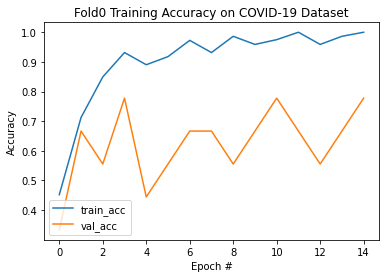

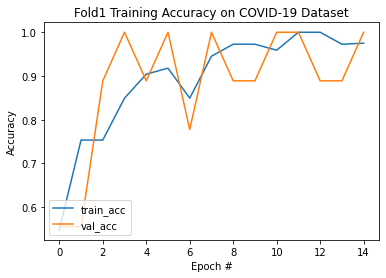

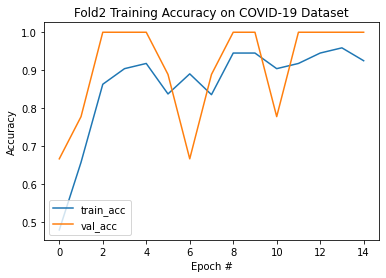

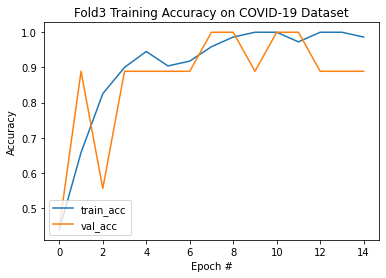

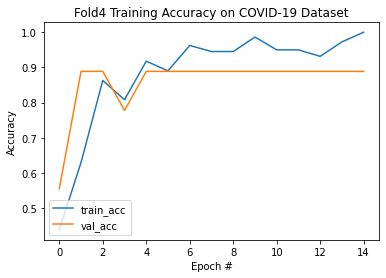

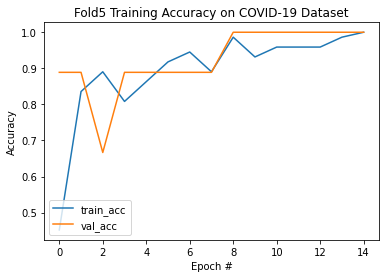

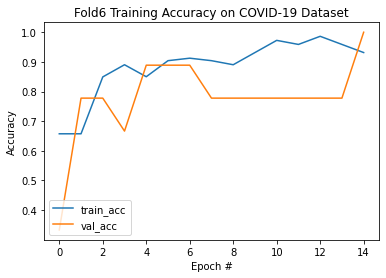

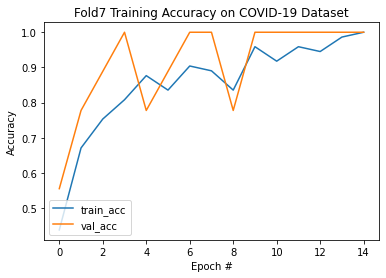

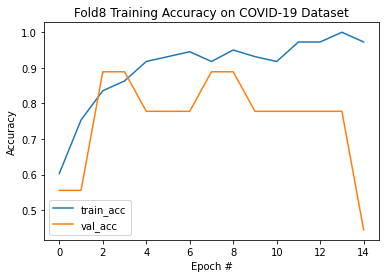

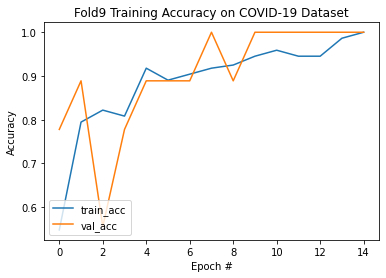

In [ ]:
for i in range(len(HVGGs)):
  H = HVGGs[i]
  N = len(H.history["accuracy"])
  plt.figure()
  plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
  plt.title("Fold"+ str(i)+" Training Accuracy on COVID-19 Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower left")
  plt.savefig("/content/drive/My Drive/Colab Notebooks/Covid_19_VGG/Fold_"+ str(i)+'VGG_Training_Accuracy.png', bbox_inches='tight')

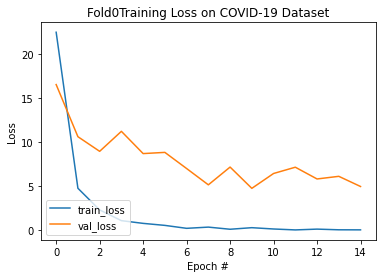

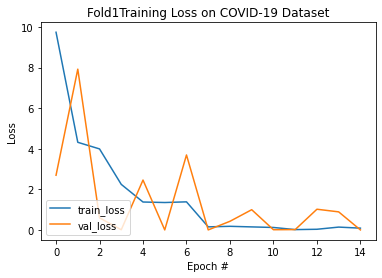

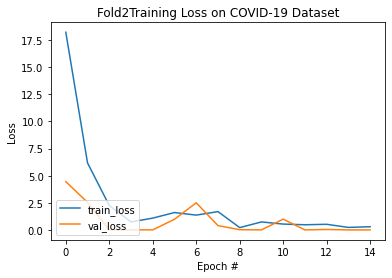

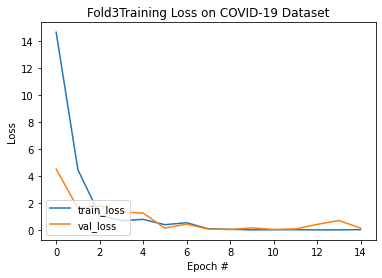

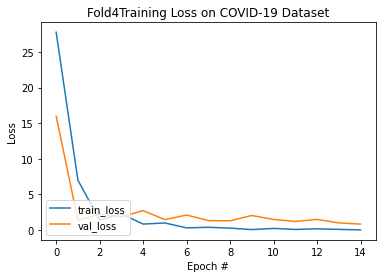

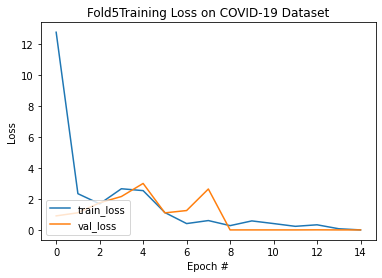

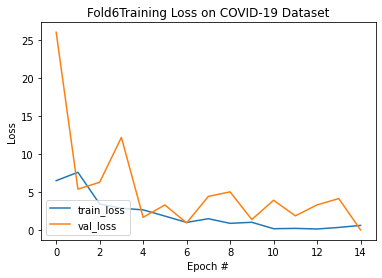

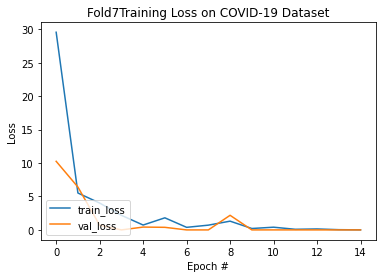

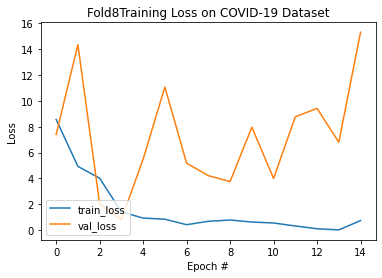

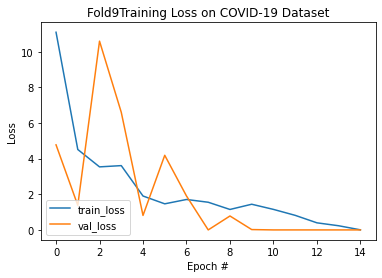

In [ ]:
for i in range(len(HVGGs)):
  H = HVGGs[i]
  N = len(H.history["accuracy"])
  plt.figure()
  plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
  plt.title("Fold"+ str(i)+"Training Loss on COVID-19 Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend(loc="lower left")
  plt.savefig("/content/drive/My Drive/Colab Notebooks/Covid_19_VGG/Fold_"+ str(i)+'VGG_Training_Loss.png', bbox_inches='tight')

In [ ]:
modelX = modelVGG_get()

HX = modelX.fit_generator(
    trainAug.flow(train_list, train_labels, batch_size=15),
    steps_per_epoch=len(train_list) // 15,
    validation_data=(test_list, test_labels),
    validation_steps=len(test_list) // 15,
    callbacks=[early_stopping_callback, checkpoint_callback],
    epochs=30)

Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 13.7696 - accuracy: 0.4000
Epoch 00001: val_loss improved from inf to 3.08041, saving model to /content/drive/My Drive/Colab Notebooks/Covid_19_VGG/VGG_best_fold.h5
6/6 [==============================] - 1s 208ms/step - loss: 13.7696 - accuracy: 0.4000 - val_loss: 3.0804 - val_accuracy: 0.7556
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 2.5300 - accuracy: 0.7889
Epoch 00002: val_loss did not improve from 3.08041
6/6 [==============================] - 1s 167ms/step - loss: 2.5300 - accuracy: 0.7889 - val_loss: 3.6152 - val_accuracy: 0.8333
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 3.6171 - accuracy: 0.7667
Epoch 00003: val_loss improved from 3.08041 to 2.41230, saving model to /content/drive/My Drive/Colab Notebooks/Covid_19_VGG/VGG_best_fold.h5
6/6 [==============================] - 1s 207ms/step - loss: 3.6171 - accuracy: 0.7667 - val_loss: 2.4123 - val_accuracy: 0.8000
Epoc

In [ ]:
predIdxsX = modelX.predict(test_list.astype('float16'), batch_size=15)
predIdxsX = np.argmax(predIdxsX, axis=1)
print(classification_report(test_labels.argmax(axis=1), predIdxsX,target_names=["COVID-19","NORMAL","PNEUMONIA"]))

              precision    recall  f1-score   support

    COVID-19       1.00      1.00      1.00        30
      NORMAL       0.97      1.00      0.98        30
   PNEUMONIA       1.00      0.97      0.98        30

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90



In [ ]:
Loss, Acc = modelX.evaluate(test_list,test_labels)
print("(Loss, Acc):",modelX.evaluate(test_list,test_labels))

3/3 [==============================] - 0s 49ms/step - loss: 0.0688 - accuracy: 0.9889
(Loss, Acc): [0.06877537816762924, 0.9888888597488403]


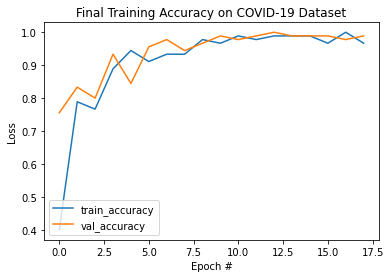

In [ ]:
H = HX
N = len(H.history["accuracy"])
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
plt.title("Final Training Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("/content/drive/My Drive/Colab Notebooks/Covid_19_VGG/VGG_final_model_Training_Accuracy.png", bbox_inches='tight')

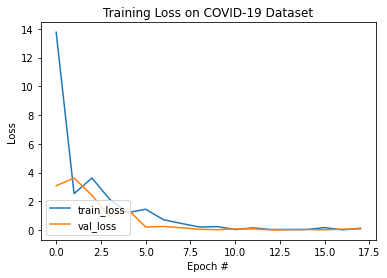

In [ ]:
H = HX
N = len(H.history["accuracy"])
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("/content/drive/My Drive/Colab Notebooks/Covid_19_VGG/VGG_final_model_Training_Loss.png", bbox_inches='tight')

In [ ]:
modelX.save("/content/drive/My Drive/Colab Notebooks/Covid_19_VGG/Covid_19_VGG_final_model.h5")